# GPTChallenge: diagnóstico a partir de HCE

Vamos a trabajar con el corpus CodEsp (textos de historial clínico etiquetados con sus códigos CIE-10 Diagnóstico)

In [1]:
import pandas as pd
import os, re
import numpy as np

pd.options.display.max_colwidth = None

In [2]:
#los códigos están en un TSV con un código por línea
train_diag = pd.read_csv("data/train/train.tsv", sep="\t", header=None, names=["archivo", "codigo"])
train_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8316 entries, 0 to 8315
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  8316 non-null   object
 1   codigo   8316 non-null   object
dtypes: object(2)
memory usage: 130.1+ KB


In [3]:
train_diag['codigo'].value_counts()

codigo
r52        163
r69        150
r50.9      142
i10        116
r59.9       95
          ... 
d37.030      1
c79.71       1
g25.0        1
l76.3        1
n81.2        1
Name: count, Length: 2194, dtype: int64

In [4]:
#cogemos la categoría superior de cada código y las agrupamos
train_diag['cat'] = train_diag['codigo'].str.extract(r'(\w\d\d)')
print(train_diag['cat'].value_counts())
train_diag['cat'].nunique()

cat
r52    163
r10    163
r59    160
r69    150
r50    144
      ... 
c31      1
d62      1
s53      1
s34      1
n81      1
Name: count, Length: 918, dtype: int64


918

In [5]:
categories=train_diag['cat'].value_counts()[:10]
top_categorias = categories.index.to_list()
print(top_categorias)

['r52', 'r10', 'r59', 'r69', 'r50', 'r60', 'i10', 'r11', 'n28', 'd49']


In [6]:
#seleccionamos sólo las etiquetas de este subconjunto
train_diag = train_diag[np.isin(train_diag['cat'], top_categorias)]

In [7]:
#cargamos los dos conjuntos de train
path = 'data/train/text_files/'

corpus = []
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    #buscamos códigos
    file = f[:-4]
    codigos = train_diag.query('archivo==@file')['cat'].to_list()
    codigos = list(set(codigos))
    if codigos:
        corpus.append({
            'archivo': file,
            'texto': texto,
            'codigos': codigos
        })
    
df_train = pd.DataFrame(corpus).set_index('archivo')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, S0004-06142005000700014-1 to S2340-98942015000100005-1
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   texto    562 non-null    object
 1   codigos  562 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


In [8]:
df_train.sample(3)

texto  \
archivo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Cargar los textos del conjunto de test

In [9]:
#los códigos están en un TSV con un código por línea
test_diag = pd.read_csv("data/test/test.tsv", sep="\t", header=None, names=['archivo'])
test_diag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   archivo  192 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


In [10]:
path = 'data/test/text_files/'

# Lista para almacenar los textos y sus códigos correspondientes
corpus = []

# Itera sobre los archivos de texto en el directorio
for f in [f for f in os.listdir(path) if f.endswith('.txt')]:
    with open(os.path.join(path, f), encoding="utf8") as text:
        texto = text.read()
    
    # Extrae el código del nombre del archivo
    file = f[:-4]
    
    # Agrega el texto al corpus
    corpus.append({
        'archivo': file,
        'texto': texto
    })

# Crea un DataFrame a partir del corpus
df_test = pd.DataFrame(corpus).set_index('archivo')

In [11]:
df_test.sample(3)

,texto
archivo,
S0004-06142010000300011-1,"Paciente de 24 años con un hermano gemelo que en Diciembre de 2005 fue intervenido de neoplasia combinada (adenocarcinoma mucinoso y carcinoide de células caliciformes, T4N2M1) que infiltraba la pared apendicular y el meso, con múltiples implantes peritoneales y afectación de 8 de los 29 ganglios aislados. Se sometió a hemicolectomía derecha, peritonectomía y resección de implantes macroscópicos de peritoneo visceral. Posteriormente se inició tratamiento quimioterápico coadyuvante con el esquema mFOLFOX4 por 12 ciclos, con episodios de diarrea tras segundo y tercer ciclo y reacción hurticariforme tras el 7o. Al inicio de la quimioterapia el 5HIAA en orina de 24 horas estaba dentro de los parámetros normales y el rastreo corporal con In.111 pentreótida y SPECT no presentaron alteraciones.\nDiez meses tras la cirugía presentó un cuadro de dolor testicular agudo. A la exploración física presentó teste derecho horinzontalizado, aumentado de tamaño y de consistencia dura e irregular en polo superior así como engrosamiento de cordón espermático. En la ecografía doppler testicular el testículo derecho presentó aumento de calibre de las estructuras vasculares, epidídimo engrosado, hipoecoico y con vascularización periférica. Se observó contenido escrotal anecoico con contenido ecogénico móvil, compatible con hidrocele complicado (piocele y hematocele...). Se decidió exploración quirúrgica urgente en la que se observó hematocele y engrosamiento con induración de la vaginal testicular. La anatomía patológica intraoperatoria se informó de infiltración por adenocarcinoma mucinoso. Se realizó orquiectomía radical derecha con ligadura del cordón a raíz del escroto. El análisis anatomopatológico definitivo mostró una neoplasia de la vaginal testicular configurada por lagos de moco y grupos de células epiteliales, la mayoría en con morfología de anillo de sello, sin afectación del epidídimo ni del testículo.\n\nTras la cirugía testicular se administró quimioterapia con esquema FOLFIRI más BEVACIZUMAB en el 3er ciclo. Nueve meses tras la orquiectomía el paciente presentó progresión hepática, pancreática y adenopática regional, presentando cuadros suboclusivos. Falleció a los 21 meses del diagnóstico.\n\n"
S1139-76322015000100012-4,"Varón de cinco años que presenta eritema perianal acompañado de dolor anal al defecar, afebril. Se recogen frotis anal y faríngeo y se realiza test rápido de detección de estreptococo, que resulta positivo en el anal, creciendo EBHGA en el cultivo rectal. Se inicia tratamiento con penicilina oral. A los 20 días regresa porque, pese a mejorar inicialmente, ha reaparecido el eritema con menor intensidad acompañado de estreñimiento y fisuras a la exploración. Se pauta mupirocina tópica con mejoría parcial del cuadro a los cuatro días, asociándose clotrimazol tópico por sospecha de sobreinfección fúngica, con resolución final del cuadro.\n"
S0365-66912012000200003-1,"Mujer de 66 años de edad remitida a nuestro Servicio por clínica de uveítis en ojo derecho desde hacía un año. La paciente refería disminución de visión en dicho ojo pero no contaba miodesopsias, ni metamorfopsias. Entre los antecedentes médicos destacaba que hace doce años sufrió una hemorragia intracraneal que requirió intervención quirúrgica y transfusión de dos unidades de concentrado de hematíes.\nEn la exploración oftalmológica la mejor agudeza visual corregida (MAVC) era 8/20 en el ojo derecho y 10/20 en el ojo izquierdo. En el examen con lámpara de hendidura se observaban restos celulares en vítreo sin signos de actividad. En el examen de fondo de ojo se observaba membrana epimacular en ambos ojos, no se encontraron signos de vasculitis retiniana, ni la presencia de snowballs o snowbanks. Con la tomografía de coherencia óptica se confirmaba la membrana epimacular. Se le diagnósticó una uveítis intermedia de etiología desconocida.\n\nEn los meses siguientes la paciente desarrolló debilidad progresiva en miem

## Binarizar las etiquetas

In [12]:
# para entrenar un clasificador multi-etiqueta generamos una matriz binaria de las etiquetas
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(df_train['codigos'])

#Guardamos las clases utilizadas en el conjunto de train
clases = mlb.classes_
num_classes = clases.shape
print(num_classes[0])

10


## Procesamiento del lenguaje natural

In [13]:
import utils

df_train_clean = utils.clean_corpus(df_train, column_name='texto')
df_test_clean = utils.clean_corpus(df_test, column_name='texto')

In [15]:
# Hacerlo solo la primera vez

#import nltk
#nltk.download('punkt')

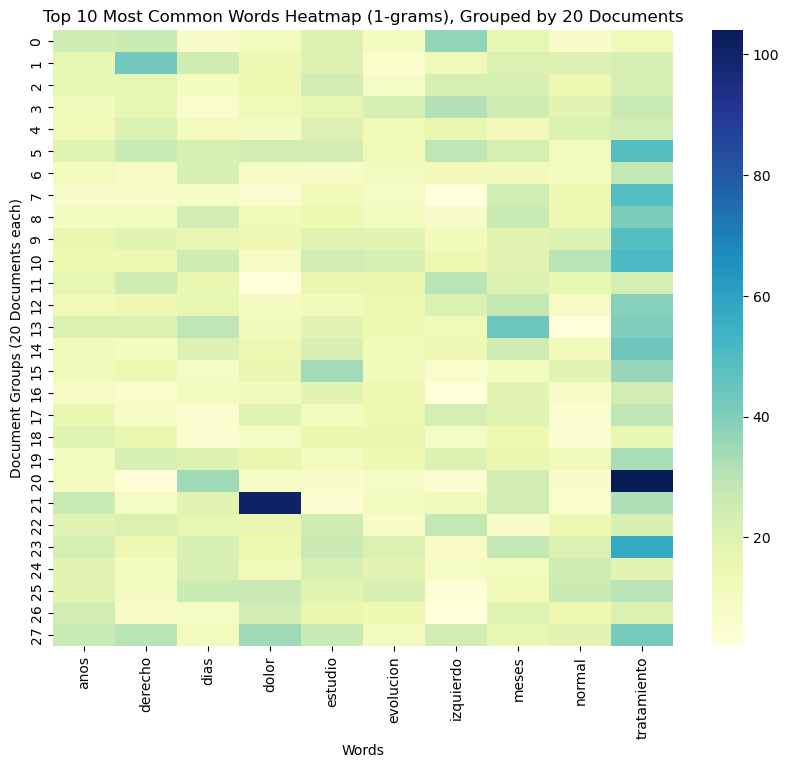

In [16]:
#Hay un vocabulario demasiado grande como para representarlo en una BoW

utils.plot_bow_heatmap(df_train_clean, column_name='texto', n_words=10, n_grams=1)

## Modelos

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


In [33]:
# Vectorizar el texto utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(df_train_clean['texto'])

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_vectorized, y_train, test_size=0.2, random_state=42)

In [34]:
model = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier()))
])

In [35]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.07079646017699115
Validation F1-score: 0.2645914396887159


In [43]:
from xgboost import XGBClassifier

In [44]:
model2 = Pipeline([
    ('clf', OneVsRestClassifier(XGBClassifier()))
])

In [45]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model2.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model2.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.4336283185840708
Validation F1-score: 0.8115942028985508


In [46]:
from sklearn.ensemble import AdaBoostClassifier

In [48]:
model3 = Pipeline([
    ('clf', OneVsRestClassifier(AdaBoostClassifier()))
])

In [49]:
# Entrenar el modelo con los datos de entrenamiento y validar con los datos de validación
model3.fit(X_train_split, y_train_split)

# Realizar predicciones en el conjunto de validación
y_val_pred = model3.predict(X_val_split)

# Calcular la precisión y F1-score en el conjunto de validación
accuracy_val = accuracy_score(y_val_split, y_val_pred)
f1_val = f1_score(y_val_split, y_val_pred, average='micro')

print("Validation Accuracy:", accuracy_val)
print("Validation F1-score:", f1_val)

Validation Accuracy: 0.4424778761061947
Validation F1-score: 0.815347721822542


## Guardar predicciones de Test